## Reducción de la Dimensionalidad

C:\Users\rimel\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


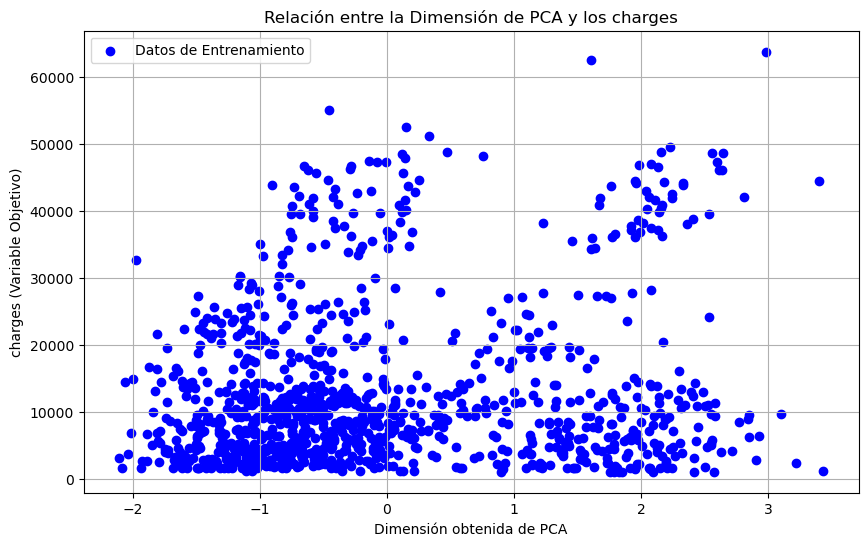

Tiempo de preprocesamiento: 4.221264123916626 segundos
**********************************************************************************
104. Combinación: age, bmi, region_southeast, sex
   Máximo EA: 46143.28
   EA Medio: 8999.92
   R^2: 0.0431
   Tiempo de Entrenamiento: 0.008008 segundos
   Tiempo de Prueba: 0.000000 segundos
------------------------------------------------------------------------------------------
181. Combinación: age, bmi, region_southeast, children, sex
   Máximo EA: 45930.09
   EA Medio: 9002.59
   R^2: 0.0444
   Tiempo de Entrenamiento: 0.000000 segundos
   Tiempo de Prueba: 0.000000 segundos
------------------------------------------------------------------------------------------
39. Combinación: age, bmi, region_southeast
   Máximo EA: 46432.31
   EA Medio: 9005.55
   R^2: 0.0413
   Tiempo de Entrenamiento: 0.000000 segundos
   Tiempo de Prueba: 0.000000 segundos
------------------------------------------------------------------------------------------
19.

In [5]:
import time
import pandas as pd
from itertools import combinations
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Cargar datos desde el archivo CSV
df_datos = pd.read_csv("datos/insurance.csv")

# Codificación One Hot para la columna 'region'
codificador_one_hot = OneHotEncoder(sparse=False)
codificacion_one_hot = codificador_one_hot.fit_transform(df_datos[['region']])
arr_nombre_nuevas_columnas = ['region_' + str(cat) for cat in codificador_one_hot.categories_[0]]
df_nuevas_columnas_one_hot = pd.DataFrame(codificacion_one_hot, columns=arr_nombre_nuevas_columnas)
df_datos = pd.concat([df_datos, df_nuevas_columnas_one_hot], axis=1)

# Columnas incluyendo 'region'
columnas_especificas = ['age', 'bmi'] + arr_nombre_nuevas_columnas + ['children', 'sex']

# Crear conjuntos de datos de entrenamiento y prueba para las columnas seleccionadas
df_X = pd.DataFrame(df_datos, columns=columnas_especificas)
df_y = pd.DataFrame(df_datos, columns=['charges'])
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=100)

# Utilizar SimpleImputer para llenar valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
df_X_train_imputed = pd.DataFrame(imputer.fit_transform(df_X_train), columns=df_X_train.columns)
df_X_test_imputed = pd.DataFrame(imputer.transform(df_X_test), columns=df_X_test.columns)

# Estandarizar los datos originales
scaler = StandardScaler()
df_X_train_scaled = scaler.fit_transform(df_X_train_imputed)
df_X_test_scaled = scaler.transform(df_X_test_imputed)

# Obtener los componentes principales
pca = PCA(n_components=1)
df_X_train_pca = pca.fit_transform(df_X_train_scaled)

# Crear la figura y el eje
plt.figure(figsize=(10, 6))

# Graficar los datos
plt.scatter(df_X_train_pca, df_y_train, color='blue', label='Datos de Entrenamiento')

# Etiquetas y título
plt.xlabel('Dimensión obtenida de PCA')
plt.ylabel('charges (Variable Objetivo)')
plt.title('Relación entre la Dimensión de PCA y los charges')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Medir tiempo de preprocesamiento
start_time_preprocesamiento = time.time()

# Lista para almacenar los resultados
resultados = []

# Conjunto para rastrear combinaciones únicas
combinaciones_unicas = set()
# Iterar sobre el rango de columnas desde 1 hasta n
for r in range(1, len(columnas_especificas) + 1):
    # Generar combinaciones de tamaño r
    combinaciones_columnas = combinations(columnas_especificas, r)

    # Iterar sobre cada combinación de columnas
    for combo in combinaciones_columnas:
        # Verificar si la combinación ya ha sido procesada
        combinacion_ordenada = tuple(sorted(combo))
        if combinacion_ordenada in combinaciones_unicas:
            continue

        # Agregar la combinación a las combinaciones únicas
        combinaciones_unicas.add(combinacion_ordenada)

        # Crear conjuntos de datos de entrenamiento y prueba para las columnas seleccionadas
        arr_X_train_subset = df_X_train_imputed[list(combo)].copy()
        arr_X_test_subset = df_X_test_imputed[list(combo)].copy()

        # Estandarizar los datos originales
        scaler = StandardScaler()
        arr_X_train_subset_scaled = scaler.fit_transform(arr_X_train_subset)
        arr_X_test_subset_scaled = scaler.transform(arr_X_test_subset)

        # Obtener los componentes principales
        pca = PCA(n_components=1)
        arr_X_train_pca = pca.fit_transform(arr_X_train_subset_scaled)

        # Crear y entrenar el modelo de regresión lineal
        regresion_lineal = linear_model.LinearRegression()
        
        start_time_entrenamiento = time.time()  # Iniciar tiempo de entrenamiento
        modelo_regresion_lineal = regresion_lineal.fit(arr_X_train_pca, df_y_train)
        end_time_entrenamiento = time.time()    # Finalizar tiempo de entrenamiento

        # Predicciones
        start_time_prueba = time.time()  # Iniciar tiempo de prueba
        arr_X_test_pca = pca.transform(arr_X_test_subset_scaled)
        arr_y_test_predicho = modelo_regresion_lineal.predict(arr_X_test_pca)
        end_time_prueba = time.time()    # Finalizar tiempo de prueba

        # Métricas de evaluación del modelo
        max_ea = max_error(df_y_test, arr_y_test_predicho)
        mae = mean_absolute_error(df_y_test, arr_y_test_predicho)
        mse = mean_squared_error(df_y_test, arr_y_test_predicho)
        r2 = r2_score(df_y_test, arr_y_test_predicho)

        # Almacenar resultados en la lista
        resultados.append({
            'Combinación_Columnas': ', '.join(combo),
            'Máximo_EA': max_ea,
            'EA_Medio': mae,
            'R^2': r2,
            'Tiempo_Entrenamiento': end_time_entrenamiento - start_time_entrenamiento,
            'Tiempo_Prueba': end_time_prueba - start_time_prueba
        })

# Crear un DataFrame a partir de la lista de resultados
df_resultados = pd.DataFrame(resultados)

# Calculamos el Error Absoluto Medio (MAE)
df_resultados['EA_Medio'] = df_resultados['EA_Medio'].abs()

# Ordenar el DataFrame por MAE en orden ascendente
df_resultados = df_resultados.sort_values(by='EA_Medio', ascending=True)

# Imprimir el tiempo de preprocesamiento
print(f"Tiempo de preprocesamiento: {time.time() - start_time_preprocesamiento} segundos")
print("**********************************************************************************")
for idx, row in df_resultados.iterrows():
    print(f"{idx + 1:2d}. Combinación: {row['Combinación_Columnas']}")
    print(f"   Máximo EA: {row['Máximo_EA']:.2f}")
    print(f"   EA Medio: {row['EA_Medio']:.2f}")
    print(f"   R^2: {row['R^2']:.4f}")
    print(f"   Tiempo de Entrenamiento: {row['Tiempo_Entrenamiento']:.6f} segundos")
    print(f"   Tiempo de Prueba: {row['Tiempo_Prueba']:.6f} segundos")
    print("-" * 90)
